## Loading datasets and merging them both 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ab = pd.read_csv('ab_test.csv')
countries = pd.read_csv('countries_ab.csv')

In [3]:
ab.head()

,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [4]:
countries.head()

,id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [5]:
# here is the preview of both datasets and we will proceed to merge it on the basis od ID

In [6]:
df = ab.merge(countries , on='id' , how='left')

In [7]:
df.head()

,id,time,con_treat,page,converted,country
0,851104,11:48.6,control,old_page,0,US
1,804228,01:45.2,control,old_page,0,US
2,661590,55:06.2,treatment,new_page,0,US
3,853541,28:03.1,treatment,new_page,0,US
4,864975,52:26.2,control,old_page,1,US


In [8]:
# here is the preview of the final dataset

In [9]:
#next step is to look for null values

In [10]:
df.isnull().sum()

id           0
time         0
con_treat    0
page         0
converted    0
country      0
dtype: int64

In [11]:
# no null values are present in the dataset

## EDA

In [12]:
### Conversion rate analysis

In [13]:
# Compute conversion rates for control and treatment groups
conversion_rates = df.groupby('con_treat')['converted'].mean()
print(conversion_rates)

con_treat
control      0.120399
treatment    0.118920
Name: converted, dtype: float64


In [14]:
### User Distribution by country 

In [15]:
#users per country
country_counts = df['country'].value_counts()
print(country_counts)

country
US    206364
UK     73419
CA     14695
Name: count, dtype: int64


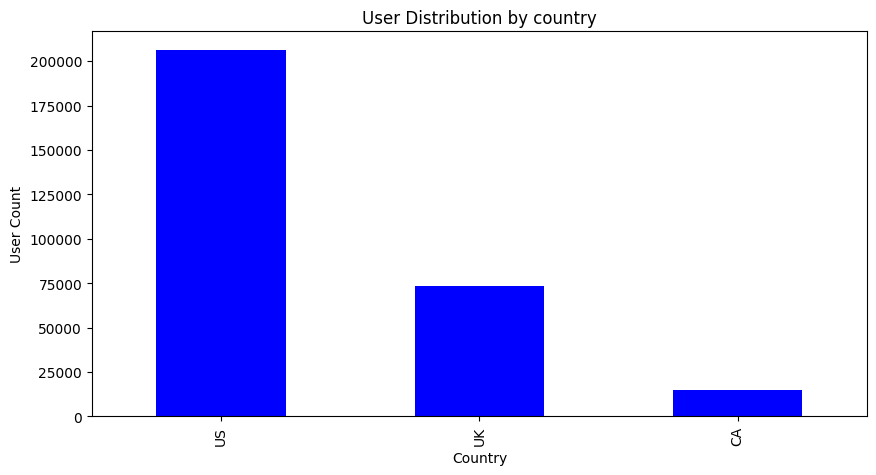

In [16]:
#plotting users per country
plt.figure(figsize=(10,5))
country_counts.plot(kind = 'bar' , color = 'blue')
plt.title("User Distribution by country")
plt.xlabel('Country')
plt.ylabel('User Count')
plt.show()

In [17]:
## page conversion rates
page_conversion_rates = df.groupby('page')['converted'].mean()
print(page_conversion_rates)

page
new_page    0.118841
old_page    0.120478
Name: converted, dtype: float64


In [18]:
## overall descriptive stats
df.describe

<bound method NDFrame.describe of             id     time  con_treat      page  converted country
0       851104  11:48.6    control  old_page          0      US
1       804228  01:45.2    control  old_page          0      US
2       661590  55:06.2  treatment  new_page          0      US
3       853541  28:03.1  treatment  new_page          0      US
4       864975  52:26.2    control  old_page          1      US
...        ...      ...        ...       ...        ...     ...
294473  751197  28:38.6    control  old_page          0      US
294474  945152  51:57.1    control  old_page          0      US
294475  734608  45:03.4    control  old_page          0      US
294476  697314  20:29.0    control  old_page          0      US
294477  715931  40:24.5  treatment  new_page          0      UK

[294478 rows x 6 columns]>

In [19]:
## Conversion rate by country
country_conversion = df.groupby('country')['converted'].mean()
print(country_conversion)

country
CA    0.115890
UK    0.120582
US    0.119599
Name: converted, dtype: float64


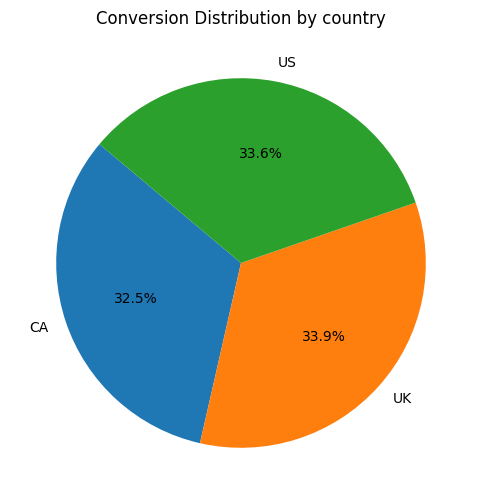

In [20]:
plt.figure(figsize=(10,6))
country_conversion.plot(kind = 'pie' , autopct='%1.1f%%' , startangle =140 , legend = False)
plt.title("Conversion Distribution by country")
plt.ylabel('')
plt.show()

In [21]:
## Time based Conversion Analysis

# Extracting hour from timestamp
df['hour']=df['time'].str[:2].astype(int)

# compute conversion rates per hour
hour_conversion = df.groupby('hour')['converted'].mean()


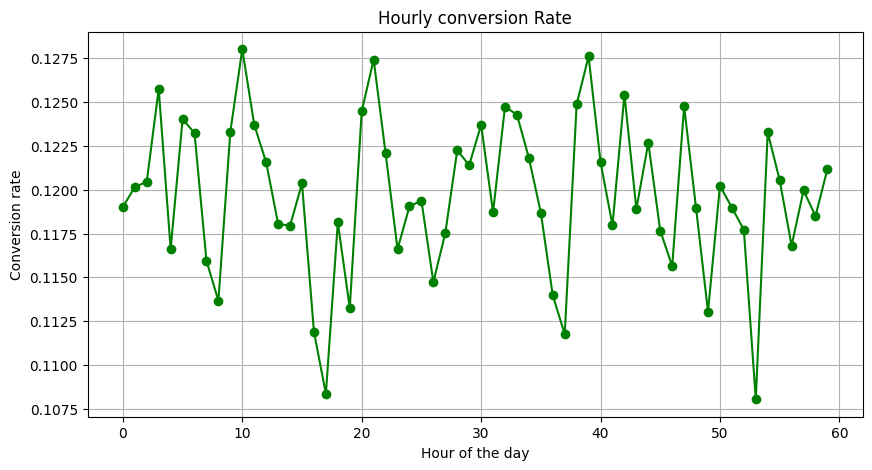

In [22]:
#plotting hour conversion
plt.figure(figsize=(10,5))
hour_conversion.plot(kind='line' , marker = 'o' , color = 'green')
plt.title('Hourly conversion Rate')
plt.xlabel('Hour of the day')
plt.ylabel('Conversion rate')
plt.grid()
plt.show()

## A/B Testing 

Before performing hypothesis testing, we define our null and alternative hypotheses:

Null Hypothesis (H₀): There is no significant difference in conversion rates between the control and treatment groups. The new page does not perform better than the old page.

Alternative Hypothesis (H₁): There is a significant difference in conversion rates between the control and treatment groups. The new page performs better (or worse) than the old page.

- Chi-Square Test → Tells if conversion rates are significantly different between groups.

- T-Test → Checks if the new page increases conversion rate on average.

- PyCaret AutoML → Finds the best predictive model for conversion trends automatically.

In [23]:
# Chi Square Test for statistical Significance
import scipy.stats as stats

#creating a cotingency table
con_table = pd.crosstab(df['con_treat'],df['converted'])

#performing chi-square test
chi2 , p , dof , expected = stats.chi2_contingency(con_table)

#Results
print(f"Chi-square statistic:{chi2}")
print(f"p-value : {p}")

Chi-square statistic:1.5159618356336582
p-value : 0.2182316121631168


According to test rule if p-value < 0.05, there is a significant difference in conversion rates.

Here through results we see that :
* Chi-square stat = 1.5159
* p-values = 0.2182

- Conclusion
1. Since the resultant p-value is greater than 0.05 we fail to reject the null hypothesis.
2. This means there is no significant difference in conversion rates between the control and Treatment Group
3. This concludes that new page does not perform better than the old page on the basis of this test.

In [24]:
# T-test to compare the conversion rates

#separating control and treatment groups conversion rates
control_group = df[df['con_treat']=='control']['converted']
treatment_group = df[df['con_treat']=='treatment']['converted']

# performing independent t-test
t_stat , p_value = stats.ttest_ind(control_group,treatment_group)

#Results
print(f"T-statistics : {t_stat}")
print(f"p_value : {p_value}")

T-statistics : 1.2369207675839395
p_value : 0.21611748562490837


Through our independent t-test the conclusion drawn is :

1. p-value ie 0.21 is greater than 0.05 through which we fail to reject the null hypothesis.
2. This means the difference in average conversion rates between control and treatment groups is not that significant statistically.
3. This leads to a conclusion that the new page does not significantly improve the conversion rates compared to the old page.

### Running Automated A/B testing with PyCaret to check if any model gives insgihts 

In [25]:
from pycaret.classification import*

# setting up automl for a/b testing
exp1 = setup(data=df , 
             target='converted', 
             categorical_features=['con_treat' , 'page' , 'country'],
             session_id=123)

# comparinf models
best_model = compare_models()

,Description,Value
0,Session id,123
1,Target,converted
2,Target type,Binary
3,Original data shape,"(294478, 7)"
4,Transformed data shape,"(294478, 9)"
5,Transformed train set shape,"(206134, 9)"
6,Transformed test set shape,"(88344, 9)"
7,Numeric features,2
8,Categorical features,3
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.8803,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2510
lightgbm,Light Gradient Boosting Machine,0.8799,0.5017,0.0001,0.0245,0.0002,-0.0006,-0.0056,1.0660


** Statistical Findings **

- Chi-Square Test & T-Test results indicate no statistically significant difference in conversion rates between the old page and the new page.

- This means that the new page does not significantly impact conversions, and rolling it out may not improve business outcomes

**High Accuracy (88%) but Low AUC (0.50) **

- AUC close to 0.50 means the model is no better than random guessing.
- This suggests that conversions are either highly imbalanced or not strongly influenced by the given features.

 ** Dummy Classifier Performs Just as Well **

- The Dummy Classifier is a baseline model that predicts based on class distribution.
- Since its accuracy is almost the same as LightGBM (~88%), it means no strong predictive pattern exists in the data.
- LightGBM does not significantly outperform random guessing, making it not useful for predicting conversions.

- Statistical tests already proved that the new page does not lead to significantly better conversions.
- AutoML confirms this → Even advanced machine learning models fail to find a meaningful pattern for conversions.
- Business Decision: Since neither statistical tests nor machine learning models provide strong evidence that the new page is better, it's not recommended to proceed with rolling it out.

- Conclusion : Instead of just changing the page design, consider A/B testing different elements (e.g., CTA buttons, offers, pricing strategies) to see if they impact conversion rates.